In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [2]:
filename = "C:/Users/rodlu/OneDrive/Escritorio/Coding_Dojo/Data_Science/Data sets/credit_customers.csv"
df = pd.read_csv(filename)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [3]:
# Crear una copia del dataframe original
df_1 = df.copy()

In [4]:
# Reemplazar valores inconsistentes columna 'credit_history': 'no credits/all paid' por 'no credits'
df_1['credit_history'] = df_1['credit_history'].replace('no credits/all paid', 'no credits')
df_1['credit_history'] = df_1['credit_history'].replace('all paid', 'no credits')
# Reemplazar valores con mwnos de 90 en la columna 'purpose' por 'other'
df_1['purpose'] = df_1['purpose'].replace('education', 'other')
df_1['purpose'] = df_1['purpose'].replace('repairs', 'other')
df_1['purpose'] = df_1['purpose'].replace('domestic appliance', 'other')
df_1['purpose'] = df_1['purpose'].replace('retraining', 'other')
# Reemplazar valores por > 100 y mantener < 100 y 'no known savings'
df_1['savings_status'] = df_1['savings_status'].replace('100<=X<500', '>100')
df_1['savings_status'] = df_1['savings_status'].replace('500<=X<1000', '>100')
df_1['savings_status'] = df_1['savings_status'].replace('>=1000', '>100')
# Dividir la columna personal_status en dos clumnas: gender y marital_status
df_1[['gender', 'marital_status']] = df_1['personal_status'].str.split(' ', n=1, expand=True)
# Eliminar la columna 'personal_status'
df_1.drop('personal_status', axis=1, inplace=True)
# Reemplazar valores en la columna 'marital_status'
df_1['marital_status'] = df_1['marital_status'].replace('mar/wid', 'not single')
df_1['marital_status'] = df_1['marital_status'].replace('div/sep', 'not single')
df_1['marital_status'] = df_1['marital_status'].replace('div/dep/mar', 'not single')
# convertir la columna 'job' en una columna binaria skilled y unskilled
df_1['job']=df_1['job'].replace('unemp/unskilled non res', 'unskilled')
df_1['job']=df_1['job'].replace('unskilled resident', 'unskilled')
df_1['job']=df_1['job'].replace('high qualif/self emp/mgmt', 'skilled')








# convertir la columna objetivo en numerica
df_1['class']=df_1['class'].replace('good', 1)
df_1['class']=df_1['class'].replace('bad', 0)

ACP para acelerar el proceso de clasificación de clientes de crédito.

In [5]:
#Formato para ML y train test split
X = df_1.drop(columns = 'class')
y = df_1['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, stratify = y)
# Instanciar los selectores de columnas categóricas y numéricas para seleccionar las columnas adecuadas
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
# Instanciar el escalador estándar y el codificador one hot
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
# Make tuples for preprocessing the categorical and numeric columns
num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)
#Instanciación de ColumnTransformer
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
#Observen que SOLO ENCAJAREMOS LOS DATOS DE ENTRENAMIENTO
col_transformer.fit(X_train)
#Ahora podemos transformar los conjuntos de entrenamiento y de prueba.
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)
#Ver las transformaciones en dataframe
X_train_df = pd.DataFrame(X_train_processed)
X_test_df = pd.DataFrame(X_test_processed)
print(np.isnan(X_train_df).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_df).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_df.shape)
print('\n')
X_train_df.head()

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (750, 52)




,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,1.244061,2.684089,-0.845753,-0.765547,0.853000,0.986324,2.291288,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.255316,-0.680787,0.931039,-1.669735,-0.838754,0.986324,-0.436436,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,-0.733429,-0.745299,0.931039,1.042831,-1.105872,-0.710335,-0.436436,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.255316,-0.916502,0.931039,1.042831,1.654357,0.986324,-0.436436,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,-0.486243,-0.833913,0.931039,0.138642,-0.215476,0.986324,2.291288,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


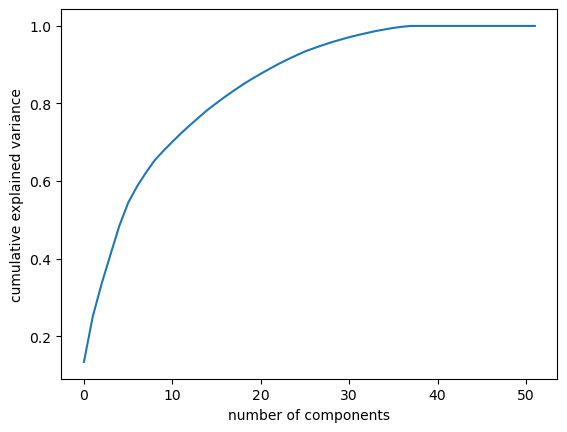

In [6]:
# Instantiate & fit data using PCA default settings
pca = PCA()
pca.fit(X_train_df)
# Plot the cumulative sum of the explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

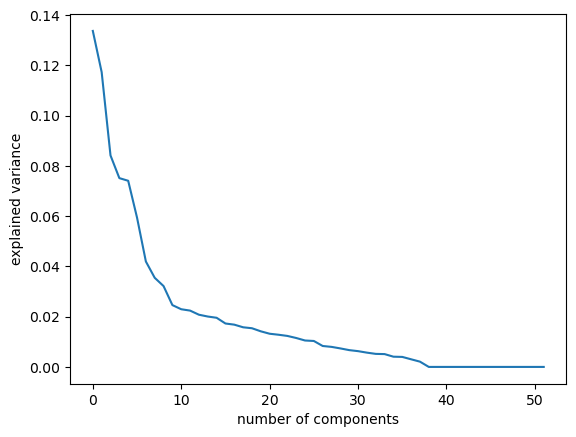

In [7]:
# Plot the explained variance ratio
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance');
plt.show()

In [11]:
# PCA with 85% explained variance
pca = PCA(n_components=0.85)
pca.fit(X_train_df)
X_train_pca = pca.transform(X_train_df)
X_test_pca = pca.transform(X_test_df)
print('shape of data is', X_train_pca.shape)
print('\n')
print('shape of data is', X_test_pca.shape)
print('\n')
print('All data in X_train_pca are', X_train_pca.dtype)
print('All data in X_test_pca are', X_test_pca.dtype)
print('\n')
print(np.isnan(X_train_pca).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_pca).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_pca are', X_train_pca.dtype)
print('All data in X_test_pca are', X_test_pca.dtype)
print('\n')
print('shape of data is', X_train_pca.shape)
print('\n')
X_train_pca_df = pd.DataFrame(X_train_pca)
X_test_pca_df = pd.DataFrame(X_test_pca)
X_train_pca_df.head()

shape of data is (750, 20)


shape of data is (250, 20)


All data in X_train_pca are float64
All data in X_test_pca are float64


0 missing values in training data
0 missing values in testing data


All data in X_train_pca are float64
All data in X_test_pca are float64


shape of data is (750, 20)




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.496965,0.424254,1.954184,-0.847357,0.102756,0.185018,0.525364,0.972926,-0.342035,-0.352714,-0.478723,-0.122240,0.010618,1.006673,0.371130,-0.213070,0.224866,-0.196820,0.174297,-0.420335
1,-0.297974,0.023820,-0.310452,-2.459037,0.515840,0.153916,-0.584136,0.167988,-0.476894,0.305572,0.614617,0.093269,-0.180764,-0.951013,-0.371915,-0.091088,1.018021,-0.164942,0.144058,0.075663
2,-1.262315,-0.504697,-1.340324,1.013967,-0.238901,-1.524456,-0.296441,0.765855,-0.929960,0.781758,0.532886,0.169729,-0.459586,-0.896012,0.431134,0.288077,-0.656563,0.883862,0.421599,0.546264
3,0.287597,2.035339,-1.560286,0.167640,0.451849,0.557205,0.130082,1.215025,0.328514,-0.422126,-0.174890,0.293950,-0.059984,-0.293218,0.263967,0.014695,0.742795,-0.162112,0.109920,0.082568
4,-0.221700,1.839579,0.922475,-0.922480,-0.641664,-1.866211,0.397475,-0.349982,-0.790015,-0.052072,-0.743049,0.413675,0.563297,-0.008549,0.905418,-0.108036,0.323623,-0.545231,-0.186510,0.052375


In [12]:
# Regresión logística con PCA
# Instanciar el modelo de regresión logística
logreg = LogisticRegression(C=1.0 ,penalty='l2', max_iter=100)
# Ajustar el modelo a los datos de entrenamiento
logreg.fit(X_train_pca_df, y_train)
# Predecir los valores de la clase para los datos de prueba
y_pred = logreg.predict(X_test_pca_df)
# Predecir los valores de la clase para los datos de entrenamiento
y_pred_train = logreg.predict(X_train_pca_df)
# calcular la matriz de confusión
confusion_matrix(y_test, y_pred)
# calcular la precision
precision_score(y_test, y_pred)
# calcular el recall
recall_score(y_test, y_pred)
# calcular el f1
f1_score(y_test, y_pred)
# calcular el accuracy
accuracy_score(y_test, y_pred)
# calcular el accuracy en los datos de entrenamiento
accuracy_score(y_train, y_pred_train)
#  calcular el area bajo la curva ROC
roc_auc_score(y_test, y_pred)
# imprimir todos los resultados
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Accuracy test: ', accuracy_score(y_test, y_pred))
print('Accuracy train: ', accuracy_score(y_train, y_pred_train))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Confusion Matrix: 
 [[ 37  38]
 [ 18 157]]
Precision:  0.8051282051282052
Recall:  0.8971428571428571
F1:  0.8486486486486488
Accuracy test:  0.776
Accuracy train:  0.768
ROC AUC:  0.6952380952380952


Nuestro proyecto es de predicción de crédito utilizando diferentes técnicas de modelado. Abajo la explicación de manera sencilla cuál de los dos enfoques, ingeniería de características (IC) o Análisis de Componentes Principales (ACP), funcionó mejor en este caso.

En primer lugar, la ingeniería de características implica eliminar columnas innecesarias y corregir datos inconsistentes en tu conjunto de datos. Este enfoque se centra en seleccionar y transformar las características existentes para mejorar el rendimiento del modelo. Después de aplicar la regresión logística en el conjunto de datos con Ingeniería de Características, obtuve los siguientes resultados:

Confusion Matrix:

[[25 50]

[17 158]]
Precision: 0.7596153846153846

Recall: 0.9028571428571428

F1: 0.825065274151436

Accuracy test: 0.732

Accuracy train: 0.764

ROC AUC: 0.618095238095238

Estos números indican qué tan bien mi modelo puede predecir si un cliente es bueno o malo para tomar un crédito. Un modelo con mayor precisión, recall, F1 y exactitud general, y un valor de ROC AUC más cercano a 1, es considerado mejor.

En este Cuaderno, apliqué ACP para reducir la dimensionalidad de tu conjunto de datos. El ACP es una técnica que transforma las características originales en un conjunto más pequeño y representativo de componentes principales. Después de aplicar ACP y nuevamente la regresión logística, obtuve los siguientes resultados:

Confusion Matrix:

[[37 38]

[18 157]]

Precision: 0.8051282051282052

Recall: 0.8971428571428571

F1: 0.8486486486486488

Accuracy test: 0.776

Accuracy train: 0.768

ROC AUC: 0.6952380952380952

En este caso, los números mejoraron en comparación con el modelo con Ingeniería de Características. La precisión, el recall, el F1 y la exactitud general aumentaron, y el valor de ROC AUC también mejoró. Estos resultados indican que el modelo después de aplicar ACP tuvo un mejor rendimiento en términos de su capacidad para predecir si un cliente es bueno o malo para tomar un crédito.

En resumen, el proceso de reducción de dimensionalidad utilizando ACP mejoró los resultados de la regresión logística en comparación con el enfoque de ingeniería de características solo. Esto significa que la aplicación de ACP ayudó a capturar mejor la variabilidad y las relaciones relevantes en los datos, lo que resultó en una mejor capacidad de predicción. Por lo tanto este es el modelo elegido para este proyecto.

In [11]:
# Exportar las predicciones
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('y_pred.csv', index=False)